This project consists in using DeepESN and GruESN to predict bitcoin stock market price.

I use a dataset from kaggle (https://www.kaggle.com/mczielinski/bitcoin-historical-data) that reports price minute by minute.

# preliminary stuff 

## imports
import necessary libraries, functions and classes

In [1]:
# import mainstream libraries
import numpy as np
import pandas as pd
import math
import plotly.graph_objects as go
from IPython.display import clear_output

# import models from my implementations
from ESN_module import ESN
from DeepESN_module import DeepESN
from utils import * # auxiliary functions

## reading and visualization of data
take the data out of the csv file, plot candlestick chart

In [2]:
# read the dataset with data minute by minute.
# we takethe last 10 000 (approximately 10 weeks) and the same amount for testing
data = pd.read_csv('data.csv')
#data.index = pd.RangeIndex(len(data.index))

print(f'total number of samples given: {len(data)}')
data

total number of samples given: 13000


Timestamp      Open  ...  Weighted_Price                 Date
0      1616366520  57747.16  ...    57759.129449  2021-03-21 22:42:00
1      1616366580  57776.54  ...    57736.569842  2021-03-21 22:43:00
2      1616366640  57764.47  ...    57774.318362  2021-03-21 22:44:00
3      1616366700  57748.37  ...    57760.980994  2021-03-21 22:45:00
4      1616366760  57792.07  ...    57800.905108  2021-03-21 22:46:00
...           ...       ...  ...             ...                  ...
12995  1617148560  58714.31  ...    58692.753339  2021-03-30 23:56:00
12996  1617148620  58683.97  ...    58693.226508  2021-03-30 23:57:00
12997  1617148680  58693.43  ...    58696.198496  2021-03-30 23:58:00
12998  1617148740  58742.18  ...    58761.866202  2021-03-30 23:59:00
12999  1617148800  58767.75  ...    58764.349363  2021-03-31 00:00:00

[13000 rows x 9 columns]

In [3]:
# visualize and work on some of the data:
plot_candlesticks(data)

##Preprocessing
shift the data separating input from target output, than normalize to 0 mean and 1 varicance and separate training, validation and test data.

In [4]:
# temporal shift: we try and predict the price r minutes ahead.
r = 3

# put data inside a matrix, only ohlc values
dataset_x = data[['Open','High','Low','Close']].to_numpy()

# normalize data to 0 mean and 1 variance
dataset_x = normalize(dataset_x)

# separate input data from desired_output data: the data is shifted to the left by r positions,
# so that it goes ahead by r temporal steps w.r.t. dataset_x . 
# data_x | 1 | 2 | 3 | 4 | 1 | 2 | 3 | 4 |
#        | <-  <-  <-  <-  <-  <-  <-  <-| 
#    | / | 2 | 3 | 4 | 1 | 2 | 3 | 4 | / |
dataset_y = np.roll(dataset_x,-r,axis=0)

# discard first and last r data-points because they are not meaningfull anymore
dataset_x = dataset_x[r:np.size(dataset_x)-r]
dataset_y = dataset_y[r:np.size(dataset_y)-r]

########### check that data is properly re-arranged ###########
# y[t] = x[t+r]  
# y[t] is r steps in the future w.r.t. x[t]
for t in range(np.size(dataset_x,axis=0)-r):
  assert np.linalg.norm(dataset_x[t+r] - dataset_y[t])==0.0

# separate training data from validation and test.
train_x = dataset_x[:4000]
train_y = dataset_y[:4000]

valid_x = dataset_x[4000:5000]
valid_y = dataset_y[4000:5000]

test_x = dataset_x[5000:]
test_y = dataset_y[5000:]

print(f'\nDATA SHAPES \ntraining data: {np.shape(train_x)},{np.shape(train_y)},\nvalid data: {np.shape(valid_x)},{np.shape(valid_y)}, \ntest data: {np.shape(test_x)}, {np.shape(test_y)}')


DATA SHAPES 
training data: (4000, 4),(4000, 4),
valid data: (1000, 4),(1000, 4), 
test data: (7997, 4), (7997, 4)


# LOCAL IMPLEMENTATIONS
ESN and DeepESN

In [5]:
# When working with my implementation of ESN and DeepESN, the convention is that every data point is a column vector
# reshape data so that each data point is a column vector, we have a tensor containing datapoints in the form of column vector
train_x = train_x.reshape(-1,4,1)
train_y = train_y.reshape(-1,4,1)
valid_x = valid_x.reshape(-1,4,1)
valid_y = valid_y.reshape(-1,4,1)
test_x = test_x.reshape(-1,4,1)
test_y = test_y.reshape(-1,4,1)

## ESN shallow

In [6]:
# now that we got the data ready, we can go ahead and train a network on it, then asses the results. 
# start with an initial very simple trial using a shallow ESN, just to see if the framework is working.

# instantiate the network object
n = ESN(Nu=4, Ny=4, rho=1, Nr=100, r_density =0.1, i_density =1)

# train the network on training data.
#        train_x       train_y      washout sequence
n.train(train_x[501:],train_y[501:],train_x[:500])

# run the network on the test set and compute mse. (save output sequence to plot it togheter with real data)
err , out = n.score(test_x,test_y)
print(f'MSE on test dataset: {err}')

MSE on test dataset: 0.002041637137016022


In [7]:
# arrange the obtained data in dataframes so that we can pretty-plot them
real = ohlc_matrix_to_dataframe(test_y.reshape(-1,4)) 
predicted = ohlc_matrix_to_dataframe(out.reshape(-1,4),r=r)

# then actually plot the results:
# plot candlestick graph with an orange indicating the predicted Low value.
fig = plot_comparison_candlesticks_with_predicted_low(real, predicted)
fig.show()

## DeepESN readout concat

In [8]:
# for DeepESN I have two versions: in the first version the readout is connected the recurrent units in all reservoirs

# instantiate the network object
n = DeepESN(Nu=4, Ny=4,N=4,Nr=10,rho=0.3)

# train the network
#             train_x       train_y      washout sequence
n.train_concat(train_x[501:],train_y[501:],train_x[:500])

# run the network on the test set and compute mse. (save output sequence to plot it togheter with real data)
err , out = n.score_concat(test_x,test_y)
print(f'MSE on test dataset: {err}')

MSE on test dataset: 0.0017320034837138142


In [9]:
# we arrange the obtained data in dataframes so that we can pretty-plot them
real = ohlc_matrix_to_dataframe(test_y.reshape(-1,4)) 
predicted = ohlc_matrix_to_dataframe(out.reshape(-1,4),r=r)

# then actually plot the results:
# we plot candlestick graph with a bar indicating the predicted Low value.
fig = plot_comparison_candlesticks_with_predicted_low(real, predicted)
fig.show()

## DeepESN readout last layer

In [10]:
# in the second variation the readout is connected only to hidden units of the last layer in the stack

Nl=3 # number of recurrent layers
#instantiate the network
n = DeepESN(Nu=4, Ny=4,N=Nl,Nr=30, rho=0.2)

# train the network
#        train_x       train_y      washout sequence
n.train(train_x[501:],train_y[501:],train_x[:500],Nl-1)

# run the network on the test set and compute mse. (save output sequence to plot it togheter with real data)
err , out = n.score(test_x,test_y,Nl-1)
print(f'MSE on test dataset: {err}')

MSE on test dataset: 0.0019068381105117754


In [11]:
# we arrange the obtained data in dataframes so that we can pretty-plot them
real = ohlc_matrix_to_dataframe(test_y.reshape(-1,4)) 
predicted = ohlc_matrix_to_dataframe(out.reshape(-1,4),r=r)

# then actually plot the results:
# we plot candlestick graph with a bar indicating the predicted Low value.
fig = plot_comparison_candlesticks_with_predicted_low(real, predicted)
fig.show()

# KERAS

In [12]:
# when working with keras:
# - each point in time is a row-vector
# - I divide the sequence into sub-sequences of lenght 80
tx = train_x.reshape(-1,80,4)
ty = train_y.reshape(-1,80,4)

vx = valid_x.reshape(1,-1,4)
vy = valid_y.reshape(1,-1,4)

ttx = test_x.reshape(1,-1,4)
tty = test_y.reshape(1,-1,4)

## GruESN
Create the GruESN RZ layer, then plug it into a keras model and test

In [13]:
import tensorflow as tf
import tensorflow.keras as keras
from scipy.stats import uniform
import scipy.sparse as s

# custom initializer to build recurrent weight matrix with given spectral radius
class Recurrent_sparse_initializer(tf.keras.initializers.Initializer):
    def __call__(self, shape, dtype=None):
      # create sparse matrix with values in [-1,1]
      wrandom = s.random(shape[0],shape[1],density = 0.1, data_rvs=uniform(loc=-1,scale=2).rvs ).todense() # matrice sparsa con valori in distribuzione uniforme tra -1 e 1
      # rescale it to set spectral radius
      w = wrandom * ( 0.9 / max(np.abs(np.linalg.eigvals(wrandom))) )
      return np.array(w)

# custom cell to plug into keras.layers.RNN
class GruESNRZCell(keras.layers.Layer):

  def __init__(self, units, **kwargs):
    self.state_size = units
    super().__init__(**kwargs)

  def build(self, input_shape):
    """
      instantiate all the necessary weight matricesx
    """
    #parameters for reset gate
    self.Wrin = self.add_weight( shape=(input_shape[-1], self.state_size), initializer="uniform", trainable =True)
    self.Wr = self.add_weight(shape=(self.state_size, self.state_size), initializer="uniform", trainable =True)

    # parameters for update gate
    self.Wzin = self.add_weight(shape=(input_shape[-1], self.state_size), initializer="uniform", trainable =True)
    self.Wz = self.add_weight(shape=(self.state_size, self.state_size), initializer="uniform", trainable =True)

    # non-trainable parameters
    self.Win = self.add_weight(shape=(input_shape[-1], self.state_size), initializer="uniform", trainable =False)
    self.W = self.add_weight(shape=(self.state_size, self.state_size), initializer=Recurrent_sparse_initializer(), trainable =False)

    self.built = True
    
  def call(self, inputs, states):
    """
      implement equation of GRU neuron
    """
    u = inputs
    x_tm1 = states[0]

    r = tf.math.sigmoid( tf.matmul(inputs, self.Wrin ) + tf.matmul( x_tm1, self.Wr) )
    z = tf.math.sigmoid( tf.matmul(inputs, self.Wzin ) + tf.matmul( x_tm1, self.Wz) )
    h = tf.math.tanh( tf.matmul(inputs, self.Win) + tf.matmul( tf.math.multiply(r, x_tm1), self.W ) )
    x = tf.math.multiply( z, x_tm1) + tf.math.multiply( (tf.ones(self.state_size) - z), h  )

    return x, [x]


In [14]:
# instantiate the keras model and compile compile it
model = keras.models.Sequential([
      #keras.layers.GRU(100, stateful=True, return_sequences=True, batch_input_shape=(1, 10000, 4)), # stateful one
      keras.layers.RNN( GruESNRZCell(100),return_sequences=True, input_shape=(None, 4)),
      #keras.layers.GRU( 100,return_sequences=True, input_shape=(None, 4)),
      #keras.layers.Dense(10),  
      keras.layers.Dense(4), 
])
model.compile(optimizer="rmsprop", loss="mse", sample_weight_mode="temporal",)
print(model.summary())

# train the model
model.fit(tx,ty,epochs=15, batch_size=1, shuffle=True)
clear_output()

# run the model on the test set to get the predictions
out = model.predict(ttx)

# arrange the obtained data in dataframes so that we can pretty-plot them
real = ohlc_matrix_to_dataframe(test_y.reshape(-1,4)) 
predicted = ohlc_matrix_to_dataframe(out.reshape(-1,4),r=r)

# then actually plot the results:
# plot candlestick graph with a bar indicating the predicted Low value.
fig = plot_comparison_candlesticks_with_predicted_low(real, predicted)
fig.show()

err = MSE( out.reshape(-1,4), tty.reshape(-1,4), 500)
print(f'MSE on test dataset: {err}')

MSE on test dataset: 0.002000710175799446


# tabular data

## calculations

In [15]:
# to assess performances I try various initializations

n_trials = 50 # number of initializations

# collect results on the test set on arrays

In [ ]:
## shallow ESN
errs_ESN = [None]*n_trials
for i in range(n_trials):
  n = ESN(Nu=4, Ny=4,rho=1, Nr=100, r_density =0.1, i_density =1)
  n.train(train_x[501:],train_y[501:],train_x[:500])
  err , _ = n.score(test_x,test_y)
  errs_ESN[i] = err

In [17]:
# deepESN Concat
errs_DeepESN_concat = [None]*n_trials
for i in range(n_trials):
  n = DeepESN(Nu=4, Ny=4,N=4,Nr=10,rho=0.3)
  n.train_concat(train_x[501:],train_y[501:],train_x[:500])
  err , out = n.score_concat(test_x,test_y)
  errs_DeepESN_concat[i] = err

In [18]:
# deepESN last layer
errs_DeepESN_last = [None]*n_trials
for i in range(n_trials):
  Nl=3
  n = DeepESN(Nu=4, Ny=4,N=Nl,Nr=30, rho=0.2)
  n.train(train_x[501:],train_y[501:],train_x[:500],Nl-1)
  err , out = n.score(test_x,test_y,Nl-1)
  errs_DeepESN_last[i] = err

In [19]:
# gruESN
errs_GruESN = [None]*n_trials
for i in range(n_trials):
  model = keras.models.Sequential([
      keras.layers.RNN( GruESNRZCell(100),return_sequences=True, input_shape=(None, 4)),
      keras.layers.Dense(4), 
  ])
  model.compile(optimizer="rmsprop", loss="mse", sample_weight_mode="temporal",)
  model.fit(tx,ty,epochs=15, batch_size=1, shuffle=True,verbose=False)
  out = model.predict(ttx)
  err = MSE( out.reshape(-1,4), tty.reshape(-1,4), 500)
  print(f'MSE on test dataset: {err}')
  clear_output(wait=True)
  errs_GruESN[i] = err

MSE on test dataset: 0.00198417557916803


In [20]:
# GRU
errs_Gru = [None]*n_trials
for i in range(n_trials):
  model = keras.models.Sequential([
      keras.layers.GRU( 100, return_sequences=True, input_shape=(None, 4)),
      keras.layers.Dense(4), 
  ])
  model.compile(optimizer="adam", loss="mse", sample_weight_mode="temporal",)
  model.fit(tx,ty,epochs=20, batch_size=1, shuffle=True)
  out = model.predict(ttx)
  err = MSE( out.reshape(-1,4), tty.reshape(-1,4), 500)
  print(f'MSE on test dataset: {err}')
  clear_output(wait=True)
  errs_Gru[i] = err

Epoch 1/20
50/50 [==============================] - 3s 24ms/step - loss: 0.0740
Epoch 2/20
50/50 [==============================] - 1s 23ms/step - loss: 0.0089
Epoch 3/20
50/50 [==============================] - 1s 24ms/step - loss: 0.0074
Epoch 4/20
50/50 [==============================] - 1s 24ms/step - loss: 0.0065
Epoch 5/20
50/50 [==============================] - 1s 23ms/step - loss: 0.0057
Epoch 6/20
50/50 [==============================] - 1s 25ms/step - loss: 0.0052
Epoch 7/20
50/50 [==============================] - 1s 23ms/step - loss: 0.0048
Epoch 8/20
50/50 [==============================] - 1s 22ms/step - loss: 0.0044
Epoch 9/20
50/50 [==============================] - 1s 23ms/step - loss: 0.0042
Epoch 10/20
50/50 [==============================] - 1s 23ms/step - loss: 0.0039
Epoch 11/20
50/50 [==============================] - 1s 23ms/step - loss: 0.0036
Epoch 12/20
50/50 [==============================] - 1s 23ms/step - loss: 0.0035
Epoch 13/20
50/50 [==================

In [21]:
errs = {
    'ESN':errs_ESN,
    'DeepESN concat':errs_DeepESN_concat,
    'DeepESN last':errs_DeepESN_last,
    'GruESN': errs_GruESN,
    'GRU': errs_Gru
}
errs = pd.DataFrame(errs)

## Plotting

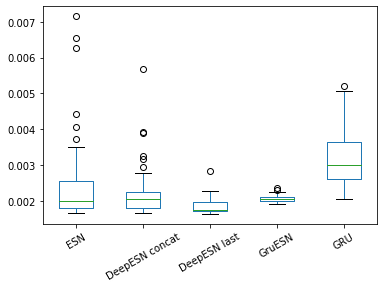

In [22]:
errs.plot(kind='box', rot='30')

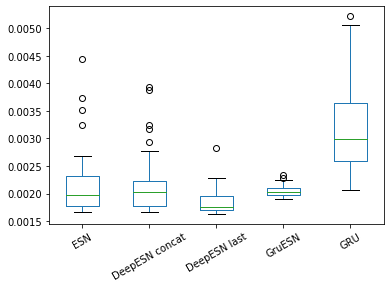

In [23]:
# drop outliers to clean the plot and make it more readable
e1 = errs.drop(errs['DeepESN concat'].idxmax()).drop(errs['ESN'].idxmax())
e1 = e1.drop(e1['ESN'].idxmax())
e1 = e1.drop(e1['ESN'].idxmax())
e1.plot(kind='box',rot=30)

In [24]:
errs.describe()

ESN  DeepESN concat  DeepESN last     GruESN        GRU
count  50.000000       50.000000     50.000000  50.000000  50.000000
mean    0.002480        0.002220      0.001856   0.002053   0.003184
std     0.001236        0.000721      0.000227   0.000096   0.000855
min     0.001660        0.001665      0.001632   0.001899   0.002061
25%     0.001786        0.001789      0.001704   0.001982   0.002594
50%     0.001998        0.002039      0.001748   0.002034   0.002989
75%     0.002550        0.002235      0.001956   0.002102   0.003642
max     0.007153        0.005667      0.002823   0.002341   0.005217

In [25]:
errs.to_csv('errs.csv',index=False)